In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import librosa.feature as ft
import wave
import struct
import librosa
import time
import librosa.display
from os import listdir
from os.path import isfile, join

In [4]:
monRepertoire = 'TestUlysse/I/'
fichiers = [f for f in listdir(monRepertoire) if isfile(join(monRepertoire, f))]
data={}
for fichier in fichiers:
    with open(monRepertoire+fichier, 'rb') as f:
        data_seul = pickle.load(f)
    data[list(data_seul.keys())[0]] = data_seul[list(data_seul.keys())[0]]
    
all_cle = list(data.keys())
print(all_cle)

['I_corde = 1.64879755625e-07.wav']


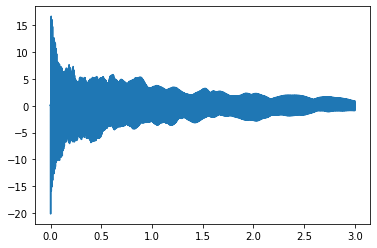

In [450]:
x = data[all_cle[10]]['data']
Fe = data[all_cle[0]]['Fe']
t = np.linspace(0,3, 3*Fe)
plt.figure()
plt.plot(t, x)

In [451]:
display(Audio(x, rate=Fe))

In [452]:
M_before = np.zeros((len(x), len(data.keys())))
x_axis = np.zeros(len(data.keys()))
i=0
for cle in all_cle:
    M_before[:,i] = data[cle]['data']
    x_axis[i] = data[cle]['I_corde']
    i+=1

inds = x_axis.argsort()
x_axis = np.take_along_axis(x_axis, inds, axis=0)
M=np.zeros((len(x), len(data.keys())))
for k in range(len(inds)):
    M[:,k] = M_before[:,inds[k]]

In [453]:
def spectral_slope(data, sr, n_fft=2048, hop_length=None, win_length=None, 
                   window='hann', center=True, pad_mode='constant'):

    S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                             center=center, pad_mode=pad_mode))
    slope = np.zeros((1,S.shape[1]))
    freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    for k in range(S.shape[1]):
        fit = np.polyfit(freq, S[:,k], 1)
        slope[0,k] =fit[0]
    return slope


def compute_features(data, sr, S=None, n_fft=2048, frame_length=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85):
    
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq = freq,
                                             win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                 center=center, pad_mode=pad_mode, freq=freq, centroid=centroid, norm=norm, p=p)
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, freq=freq, fmin=fmin, n_bands=n_bands, quantile=quantile, linear=linear)
    
    flatness = librosa.feature.spectral_flatness(y=data, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, amin=amin, power=power)
    
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                center=center, pad_mode=pad_mode, freq=freq, roll_percent=roll_percent)
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length, center=center)
    
    rms = librosa.feature.rms(y=data, S=S, frame_length=frame_length, hop_length=hop_length, center=center, pad_mode=pad_mode)
    
    slope = spectral_slope(data, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, 
                   window=window, center=center, pad_mode=pad_mode)
    
    dict_features = {}
    dict_features['spectral_centroid'] = cent
    dict_features['spectral_bandwidth'] = spec_bw
    dict_features['spectral_contrast'] = contrast
    dict_features['spectral_flatness'] = flatness
    dict_features['spectral_rolloff'] = rolloff
    dict_features['zero_crossing_rate'] = zcr
    dict_features['rms'] = rms
    dict_features['spectral_slope'] = slope
    
    return dict_features

In [454]:
data_features={}
for k in range(len(data.keys())):
    data_features[all_cle[k]] = compute_features(M[:,k], sr=Fe, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85)

In [455]:
#Ou commencer et finir la visualtion
debut = 0
fin = -10

2.9997749981249844


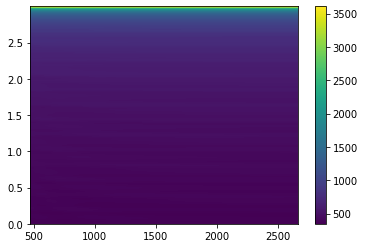

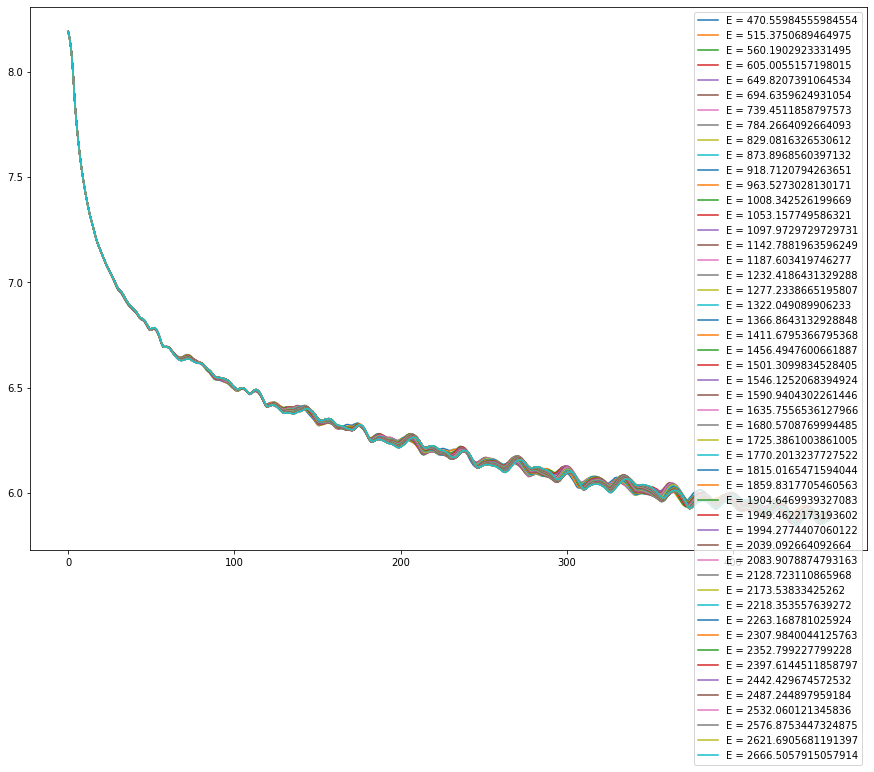

In [456]:
M_spec_bw = np.zeros((len(data_features[all_cle[0]]['spectral_bandwidth'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_spec_bw[:,i] = data_features[cle]['spectral_bandwidth'][0]
    i+=1
    
plt.figure()
print(t[fin])
c = plt.imshow(M_spec_bw[debut:fin,:],extent =[x_axis.min(), x_axis.max(), t[debut], t[fin]],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M.shape[1]):
        plt.plot(np.log(M_spec_bw[debut:fin,k]), label = 'E = '+str(x_axis[k]))
        plt.legend(loc="upper right")

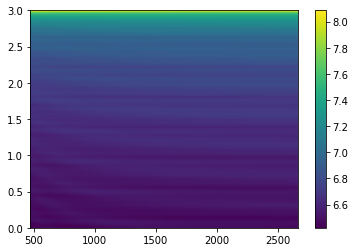

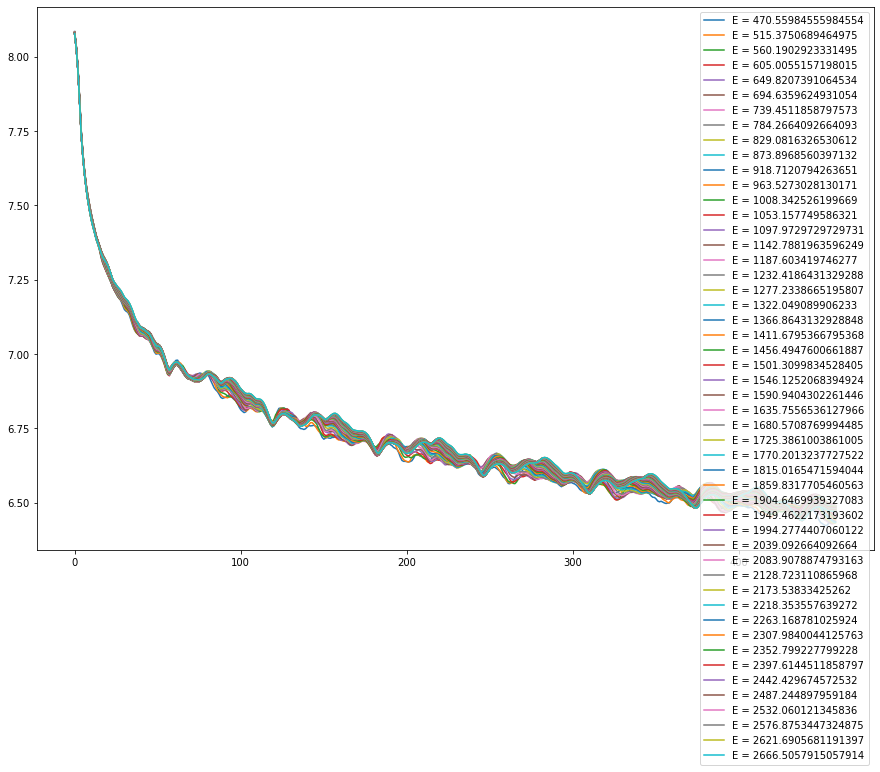

In [457]:
M_cent = np.zeros((len(data_features[all_cle[0]]['spectral_centroid'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_cent[:,i] = data_features[cle]['spectral_centroid'][0]
    i+=1
    
plt.figure()
c = plt.imshow(np.log(M_cent[debut:fin,:]),extent =[x_axis.min(), x_axis.max(), t.min(), t.max()],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M.shape[1]):

        plt.plot(np.log(M_cent[debut:fin,k]), label = 'E = '+str(x_axis[k]))
        plt.legend(loc="upper right")

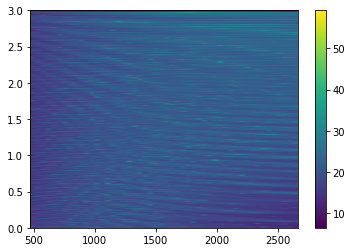

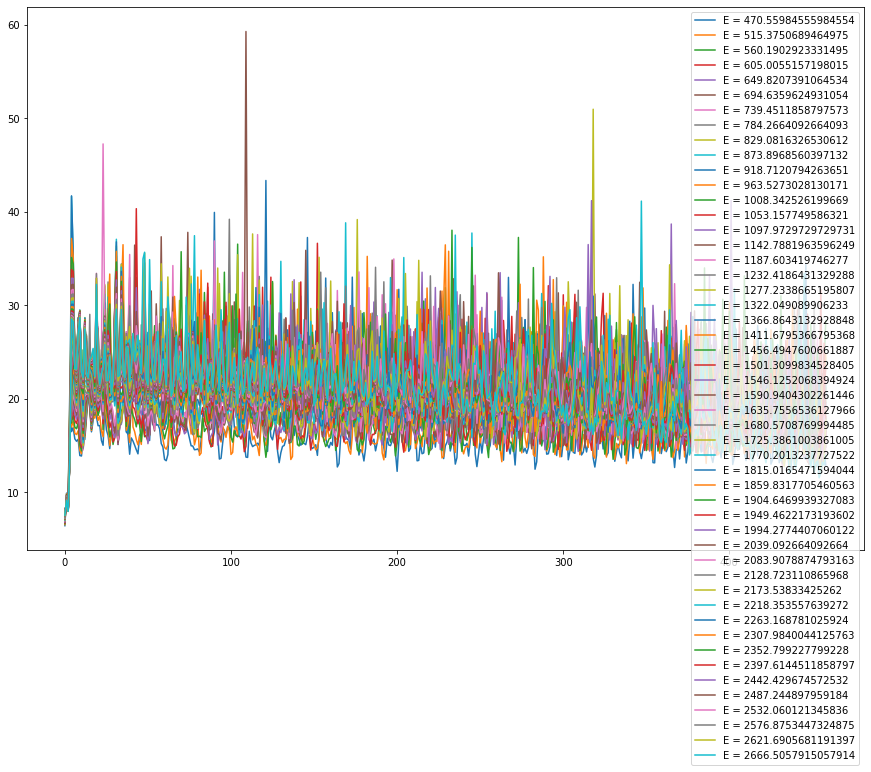

In [458]:
M_contrast = np.zeros((len(data_features[all_cle[0]]['spectral_contrast'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_contrast[:,i] = data_features[cle]['spectral_contrast'][0]
    i+=1
    
plt.figure()
c = plt.imshow(M_contrast[debut:fin,:],extent =[x_axis.min(), x_axis.max(), t.min(), t.max()],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M.shape[1]):

        plt.plot(M_contrast[debut:fin,k], label = 'E = '+str(x_axis[k]))
        plt.legend(loc="upper right")

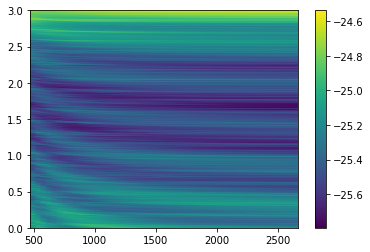

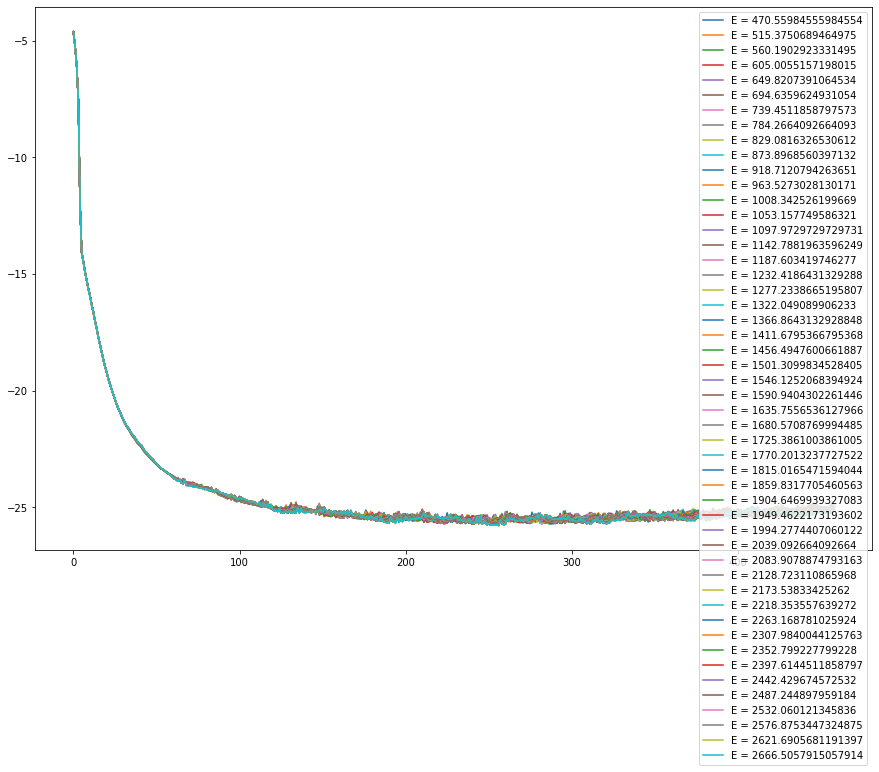

In [459]:
M_flatness = np.zeros((len(data_features[all_cle[0]]['spectral_flatness'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_flatness[:,i] = data_features[cle]['spectral_flatness'][0]
    i+=1
    
plt.figure()
c = plt.imshow(np.log(M_flatness[100:-20,:]),extent =[x_axis.min(), x_axis.max(), t.min(), t.max()],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M.shape[1]):

        plt.plot(np.log(M_flatness[debut:fin,k]), label = 'E = '+str(x_axis[k]))
        plt.legend(loc="upper right")

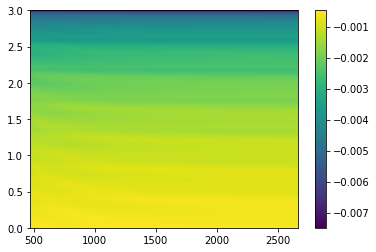

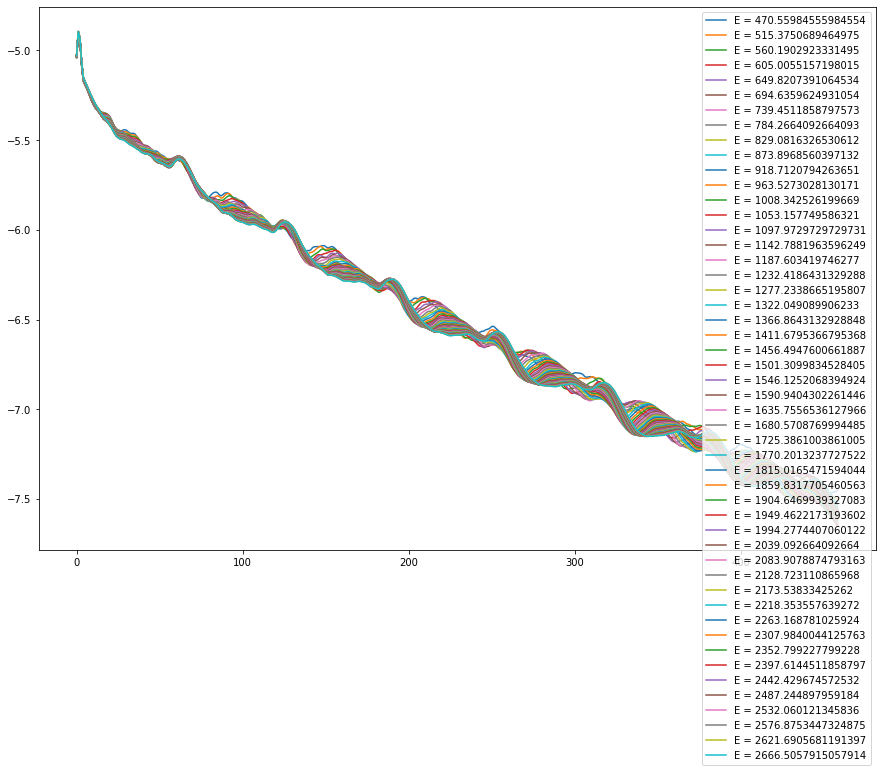

In [460]:
M_slope = np.zeros((len(data_features[all_cle[0]]['spectral_slope'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_slope[:,i] = data_features[cle]['spectral_slope'][0]
    i+=1
    
plt.figure()
c = plt.imshow(M_slope[debut:fin,:],extent =[x_axis.min(), x_axis.max(), t.min(), t.max()],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M.shape[1]):
        plt.plot(np.log(-M_slope[debut:fin,k]), label = 'E = '+str(x_axis[k]))
        plt.legend(loc="upper right")

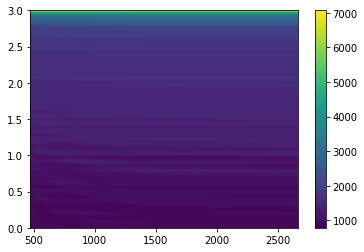

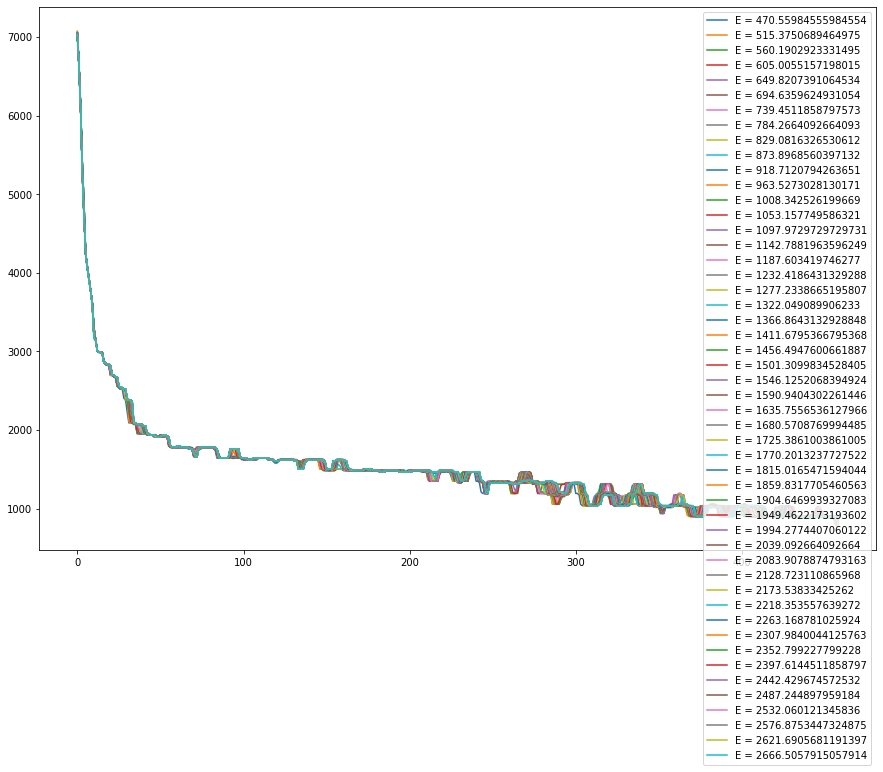

In [461]:
M_rolloff = np.zeros((len(data_features[all_cle[0]]['spectral_rolloff'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_rolloff[:,i] = data_features[cle]['spectral_rolloff'][0]
    i+=1
    
plt.figure()
c = plt.imshow(M_rolloff[debut:fin,:],extent =[x_axis.min(), x_axis.max(), t.min(), t.max()],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M_rolloff.shape[1]):
        plt.plot(M_rolloff[debut:fin,k], label = 'E = '+str(x_axis[k]))
        plt.legend(loc="upper right")

"\nfor i in range(3):\n    for j in range(2):\n        ax[i,j].set_xscale('log')\n"

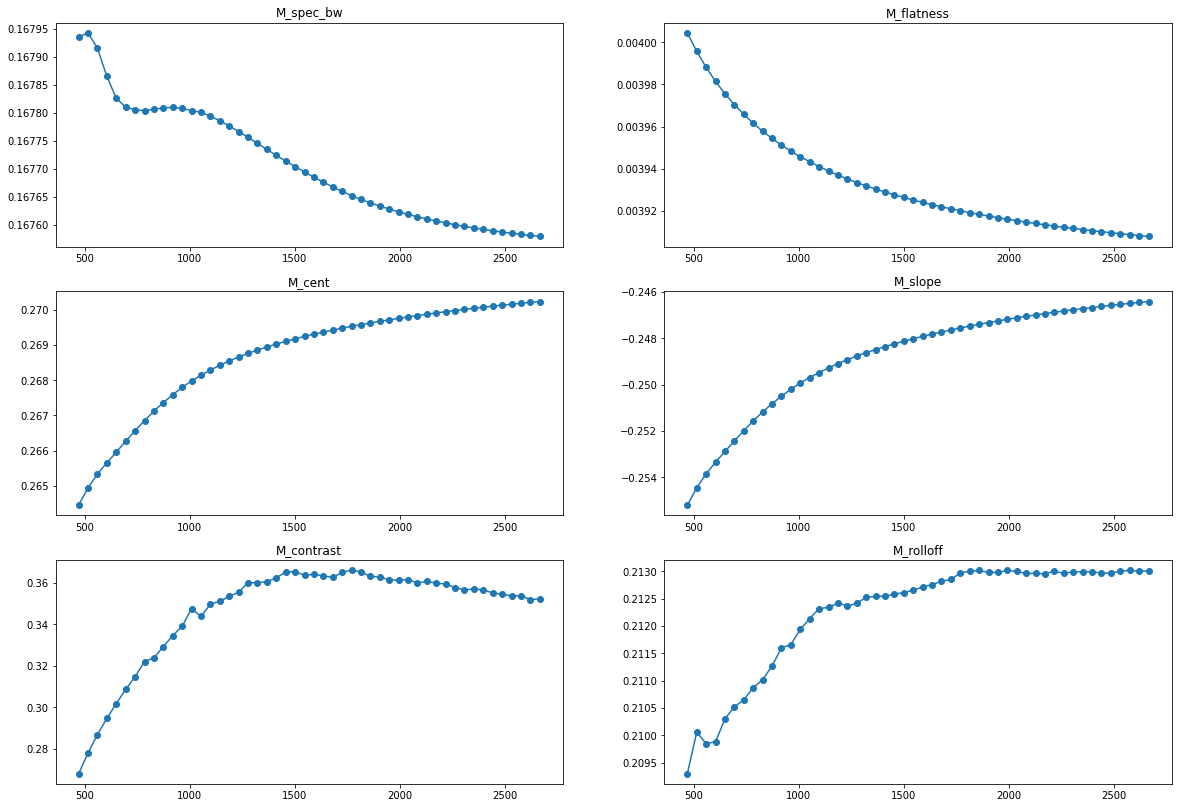

In [462]:
fig, ax = plt.subplots(3,2, figsize=(20,14))
ax[0,0].plot(x_axis,np.mean(M_spec_bw[debut:fin,:] /np.max(np.abs(M_spec_bw[debut:fin,:])), axis=0),'o-')
ax[1,0].plot(x_axis,np.mean(M_cent[debut:fin,:] /np.max(np.abs(M_cent[debut:fin,:])), axis=0),'o-')
ax[2,0].plot(x_axis,np.mean(M_contrast[debut:fin,:] /np.max(np.abs(M_contrast[debut:fin,:])), axis=0),'o-')
ax[0,1].plot(x_axis,np.mean(M_flatness[debut:fin,:] /np.max(np.abs(M_flatness[debut:fin,:])), axis=0),'o-')
ax[1,1].plot(x_axis,np.mean(M_slope[debut:fin,:] /np.max(np.abs(M_slope[debut:fin,:])), axis=0),'o-')
ax[2,1].plot(x_axis,np.mean(M_rolloff[debut:fin,:] /np.max(np.abs(M_rolloff[debut:fin,:])), axis=0),'o-')

ax[0,0].set_title("M_spec_bw")
ax[1,0].set_title("M_cent")
ax[2,0].set_title("M_contrast")
ax[0,1].set_title("M_flatness") 
ax[1,1].set_title("M_slope")
ax[2,1].set_title("M_rolloff")

'''
for i in range(3):
    for j in range(2):
        ax[i,j].set_xscale('log')
'''